### Batch source extraction

This notebook shows how to run batch to extract sources in fits images of a directory-tree. <br>
* tptp
* tolto

In [73]:
import os , glob
import matplotlib.pyplot as plt
import sewpy
import pyfits , math
import random
import numpy as np

from scipy.stats import sigmaclip

## Constants
BEAMARCSEC= 3600. 

## directories
rootdir = "/home/stephane/Science/ETGs/RadioGalaxy/calibrators"
wdir    = "%s/products"%(rootdir)
plotdir = "%s/products/plots"%(rootdir)
fitsrootdir = "/home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1315-5334/"

os.chdir(wdir)

In [74]:
## Get the list of all fits images assuming they have to be extracted.

def getFitsFiles(dir):
    list = glob.glob("%s/**/*fits"%(dir), recursive=True)
    
    return(list)

In [75]:
def runsextractor(image_file, detect_thresh=3.5, analysis_thresh=3.0):
    params = ['NUMBER', 'FLUX_ISO', 'FLUXERR_ISO', 'FLUX_AUTO', 'FLUXERR_AUTO', 'FLUX_BEST', 'FLUXERR_BEST', 'BACKGROUND', 
              'THRESHOLD', 'FLUX_MAX', 'XMAX_IMAGE', 'YMAX_IMAGE', 'XPEAK_IMAGE', 'YPEAK_IMAGE', 'ALPHAPEAK_J2000', 
              'DELTAPEAK_J2000', 'X_IMAGE', 'Y_IMAGE', 'ALPHA_SKY', 'DELTA_SKY', 'ALPHA_J2000', 'DELTA_J2000']

    config = {"DETECT_THRESH":detect_thresh, "ANALYSIS_THRESH":analysis_thresh}

    sew = sewpy.SEW(workdir="./", sexpath="/usr/bin/sextractor",params=params, config=config)

    out = sew(image_file)
    data = out["table"]
    
    ra, dec, flux, label = data['ALPHA_J2000'], data['DELTA_J2000'], data['FLUX_MAX'], data['NUMBER'].astype('int')
    
    return ra, dec, flux, label

In [76]:
# fits inforation

def getARfits(fitsimage):
    
    hdulist = pyfits.open(fitsimage)
    #hdulist.info()
    
    hdr = hdulist[0].header
    nx = int(hdr['NAXIS1'])
    ny = int(hdr['NAXIS2'])
    bmin = float(hdr['BMIN']) * BEAMARCSEC
    bmaj = float(hdr['BMAJ']) * BEAMARCSEC
    ar = math.sqrt(bmin*bmaj)
    lonpole = float(hdr['CRVAL1'])
    latpole = float(hdr['CRVAL2'])
    
    #print(hdr)
    data = hdulist[0].data
    
    return(nx,ny, bmin, bmaj , ar , lonpole , latpole)

In [77]:
## RMS estimation

def getRMSfits(fitsimage , nsample=40 , size= 20):
    
    random.seed()
    
    hdulist = pyfits.open(fitsimage)
    
    hdr = hdulist[0].header
    nx = int(hdr['NAXIS1'])
    ny = int(hdr['NAXIS2'])
    
    data = hdulist[0].data
    
    rms = []
    for i in range(nsample):
        ix = random.randint(size,int(nx/2)-size)
        iy = random.randint(size,int(ny/2)-size)
        fx = random.random()
        fy = random.random()
        
        if fx < 0.5:
            ixcenter = ix
        else:
            ixcenter = nx - ix
            
        if fy < 0.5:
            iycenter = iy
        else:
            iycenter = ny - iy
            
        datrms = data[0, 0, ixcenter-size:ixcenter+size, iycenter-size:iycenter+size]
        rms.append(np.std(datrms))
        
    
    c, low, upp = sigmaclip(rms , 3.0 , 3.0)

    rmsestimated = np.median(c)    
    return(rmsestimated)

In [78]:
## plots the sources...

def plotSources(plotdir, fitsimage, data , alpha , delta, fov, rms):
    ra  = data['ra']
    dec = data['dec']
    flux = data['flux']
    
    plt.xlim(alpha-fov/2., alpha+fov/2.)
    plt.ylim(delta-fov/2., delta+fov/2.)
    #plt.plot(ra,dec,"r*")
    # plt.plot(alpha, delta, "b+" , markersize= 10)
    plt.scatter(alpha, delta, cmap='hsv', alpha=0.75)
    
    plt.text(alpha + 0.2*fov,delta+ 0.45*fov,"RMS= %3.3f mJy"%(rms*1e3))
    figname= "%s/%s-sources.png"%(plotdir, fitsimage)
    plt.savefig(figname)
    plt.show()

In [79]:
def main(plot=True):
    lfits = getFitsFiles(fitsrootdir)
    
    res = []
    
    print("## Running sextractor...")
    for fitsimage in lfits:
        print("### Fits: %s"%(fitsimage))
        
        nx , ny , bmin, bmaj, ar, alpha, delta = getARfits(fitsimage)
        print("## NX= %d , NY= %d"%(nx,ny))
        print("## BMIN= %3.3f arcsec, BMAJ= %3.3f arcsec, AR= %3.3f arcsec"%(bmin, bmaj,ar))
        
        rms = getRMSfits(fitsimage, 40, 30)
        print("## RMS= %3.4f mJy"%(rms*1e3))
        
        dat= {}
        ra, dec , flux , label = runsextractor(fitsimage)
        dat['fits'] = fitsimage
        dat['rms'] = rms
        dat['ra']   = ra
        dat['dec']  = dec
        dat['flux'] = flux
        
        res.append(dat)  
        
        if plot:
            dr= 100./3600.   ### FOV of 100 arcsec
            plotSources(plotdir, fitsimage.split("/")[-1], dat , alpha, delta, dr , rms)
       
    return(res)

Output catalog ./uid___A002_X98124f_X2127.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


## Running sextractor...
### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1315-5334/Band6/uid___A002_X98124f_X2127.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.self3.substracted.cont.image.fits
## NX= 256 , NY= 256
## BMIN= 0.934 arcsec, BMAJ= 1.324 arcsec, AR= 1.112 arcsec
## RMS= 0.0926 mJy


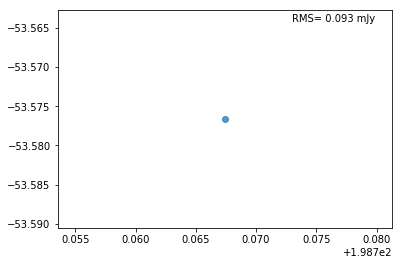

### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1315-5334/Band6/uid___A002_Xb7d0ee_Xcc9d.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.self3.substracted.cont.image.fits


Output catalog ./uid___A002_Xb7d0ee_Xcc9d.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


## NX= 1400 , NY= 1400
## BMIN= 0.144 arcsec, BMAJ= 0.239 arcsec, AR= 0.185 arcsec
## RMS= 0.0958 mJy


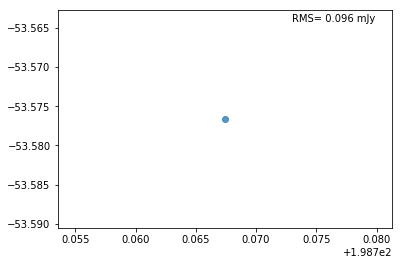

Output catalog ./uid___A002_X98124f_X2127.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1315-5334/Band6/uid___A002_X98124f_X2127.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.cont4.image.fits
## NX= 200 , NY= 200
## BMIN= 0.926 arcsec, BMAJ= 1.314 arcsec, AR= 1.103 arcsec
## RMS= 0.0952 mJy


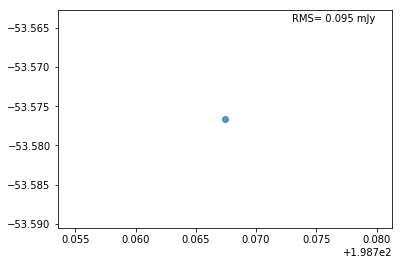

### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1315-5334/Band6/uid___A002_Xb7d0ee_Xcc9d.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.cont4.image.fits
## NX= 1280 , NY= 1280
## BMIN= 0.139 arcsec, BMAJ= 0.240 arcsec, AR= 0.182 arcsec


Output catalog ./uid___A002_Xb7d0ee_Xcc9d.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.cont4.image.cat.txt already exists, I will overwrite it


## RMS= 0.1008 mJy


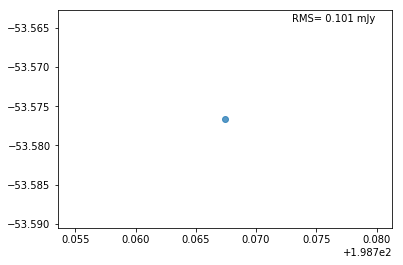

Output catalog ./uid___A002_Xb7d0ee_X516a.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1315-5334/Band3/uid___A002_Xb7d0ee_X516a.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.self3.substracted.cont.image.fits
## NX= 1400 , NY= 1400
## BMIN= 0.312 arcsec, BMAJ= 0.442 arcsec, AR= 0.372 arcsec
## RMS= 0.0809 mJy


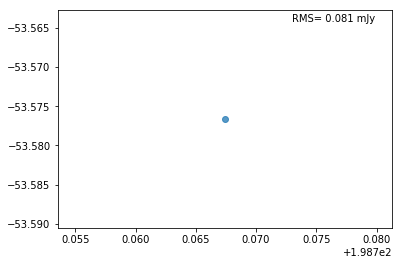

Output catalog ./uid___A002_Xb7d0ee_X516a.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1315-5334/Band3/uid___A002_Xb7d0ee_X516a.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.cont4.image.fits
## NX= 1280 , NY= 1280
## BMIN= 0.313 arcsec, BMAJ= 0.440 arcsec, AR= 0.371 arcsec
## RMS= 0.0872 mJy


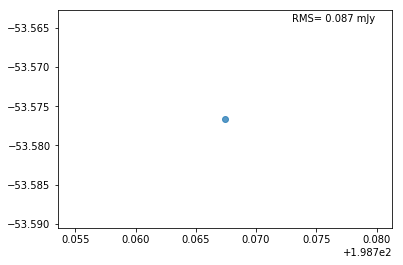

Output catalog ./uid___A002_Xb74a0f_X2b72.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1315-5334/Band3/uid___A002_Xb74a0f_X2b72.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.cont4.image.fits
## NX= 1200 , NY= 1200
## BMIN= 0.393 arcsec, BMAJ= 0.545 arcsec, AR= 0.463 arcsec
## RMS= 0.1870 mJy


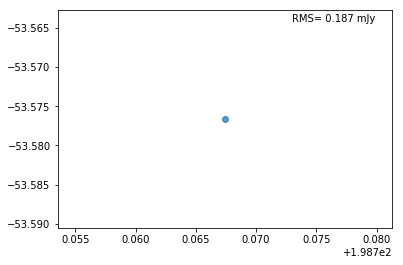

Output catalog ./uid___A002_Xb74a0f_X2b72.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1315-5334/Band3/uid___A002_Xb74a0f_X2b72.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.self3.substracted.cont.image.fits
## NX= 1200 , NY= 1200
## BMIN= 0.392 arcsec, BMAJ= 0.546 arcsec, AR= 0.463 arcsec
## RMS= 0.1788 mJy


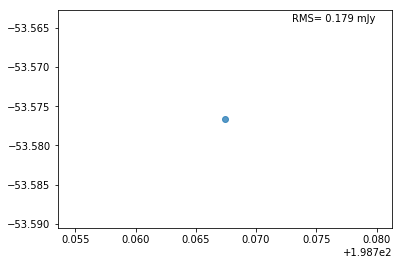

In [80]:
allres = main()